In [1]:
import os, sys, glob
import numpy as np
np.seterr(divide='ignore') # ignode divide by zero warnings
import astropy.io.fits as fits
from astropy.table import Table
import fitsio
import healpy as hp
from astropy.coordinates import SkyCoord
import astropy.units as units
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import warnings; warnings.simplefilter('ignore')

sys.path.append('/global/homes/q/qmxp55/DESI/omarlibs')
from main_def import get_random, flux_to_mag, get_sweep_whole, bgsmask, getGeoCuts, get_dict
from main_def import set_mwd, get_radec_mw, get_systplot, plot_sysdens, get_isdesi, get_reg
from main_def import getStats, flow
from photometric_def import get_stars, get_galaxies
import raichoorlib

# add GRAPHVIZ bin files to PATH, otherwise it doesn't find them
#os.environ['PATH'] = '/global/u2/q/qmxp55/bin'

%load_ext autoreload
%autoreload 2

In [2]:
#input files

inptfiles = {}

#inptfiles['dr8randroot']= '/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randoms/randoms-inside-dr8-0.31.0-'
inptfiles['dr8pix']     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
inptfiles['desitile']   = '/global/cscratch1/sd/raichoor/desi-tiles-viewer.fits' # from Eddie, see [desi-survey 647]
inptfiles['bgsdr8']   = '/global/cscratch1/sd/qmxp55/bgs_dr8_0.31.1+cuts.npy'
inptfiles['bgssvtiles'] = '/global/cscratch1/sd/qmxp55/BGS_SV_30_3x_superset60_JUL2019.fits'
inptfiles['bgsdr8relax'] = '/global/cscratch1/sd/qmxp55/bgs_dr8_0.31.1_relaxed.npy'
inptfiles['dr8maskbitsource'] = '/global/cscratch1/sd/qmxp55/sweep_files/dr8_sweep_whole_maskbitsource.npy'
#inptfiles['bgsdr8relax-north'] = '/global/cscratch1/sd/qmxp55/desitarget_output/targets-BGS-main-dr8.0-1-north.fits'
#inptfiles['bgsdr8relax-south'] = '/global/cscratch1/sd/qmxp55/desitarget_output/targets-BGS-main-dr8.0-1-south.fits'

for file in inptfiles.keys():
    print(file, '\t=', inptfiles[file])
    
    
#settings
org          = 120  # centre ra for mollweide plots
Nranfiles = 3
veto_maskbits= [1, 12, 13] #BGS only applies the BS masking
dec_resol_ns = 32.375 # ADM dec to split north/south
projection   = 'mollweide'
reg = 'south'
# for healpy
hdr          = fits.getheader(inptfiles['dr8pix'],1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

dr8pix 	= /project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits
desitile 	= /global/cscratch1/sd/raichoor/desi-tiles-viewer.fits
bgsdr8 	= /global/cscratch1/sd/qmxp55/bgs_dr8_0.31.1+cuts.npy
bgssvtiles 	= /global/cscratch1/sd/qmxp55/BGS_SV_30_3x_superset60_JUL2019.fits
bgsdr8relax 	= /global/cscratch1/sd/qmxp55/bgs_dr8_0.31.1_relaxed.npy
dr8maskbitsource 	= /global/cscratch1/sd/qmxp55/sweep_files/dr8_sweep_whole_maskbitsource.npy


In [3]:
start = raichoorlib.get_date()
# load catalogue
cat =  get_sweep_whole(dr='dr8-south', rlimit=20, maskbitsource=False, bgsbits=True, opt='1') # catalogue
catindesi = get_isdesi(cat['RA'],cat['DEC']) # True if is in desi footprint
hppix_cat = hp.ang2pix(nside,(90.-cat['DEC'])*np.pi/180.,cat['RA']*np.pi/180.,nest=nest) # catalogue hp pixels array

c = SkyCoord(cat['RA']*units.degree,cat['DEC']*units.degree, frame='icrs')
galb = c.galactic.b.value # galb coordinate
end = raichoorlib.get_date()
print(start)
print(end)

sweep file already exist at:/global/cscratch1/sd/qmxp55/sweep_files/dr8-south_sweep_whole_rlimit_20.npy
Total run time: 3.292656 sec
1207 nearby objects
2019-12-06 15:20:03
2019-12-06 15:21:13


In [4]:
randoms = get_random(N=Nranfiles, sweepsize=None, dr='dr8') # randoms

indesiranfile = '/global/cscratch1/sd/qmxp55/random_dr8_indesi_N%s.npy' %(Nranfiles)
is_indesiranfile = os.path.isfile(indesiranfile)
if is_indesiranfile: 
    ranindesi = np.load(indesiranfile)
else: 
    ranindesi = get_isdesi(randoms['RA'],randoms['DEC']) # True is is in desi footprint
    np.save(indesiranfile, ranindesi)
    
hppixranfile = '/global/cscratch1/sd/qmxp55/hppix_dr8_random_N%s.npy' %(Nranfiles)
is_hppixranfile = os.path.isfile(hppixranfile)
if is_hppixranfile: 
    hppix_ran = np.load(hppixranfile)
else: 
    hppix_ran = hp.ang2pix(nside,(90.-np.array(randoms['DEC']))*np.pi/180.,np.array(randoms['RA'])*np.pi/180.,nest=nest) # randoms hp pixels array
    np.save(hppixranfile, hppix_ran)

RANDOM file already exist at:/global/cscratch1/sd/qmxp55/dr8_random_N3.npy
Total run time: 0.000540 sec
Weight of /global/cscratch1/sd/qmxp55/dr8_random_N3.npy catalogue: 6.82 GB


In [5]:
#bgsmask = bgsmask()
rancuts = getGeoCuts(randoms)

In [6]:
hpdict = get_dict(cat=cat, pixmapfile=inptfiles['dr8pix'], hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=None, maskcat=None, Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=catindesi, 
                            namesels=bgsmask(), galb=galb, survey='bgs')

1207 nearby objects


In [7]:
# get regions for randoms

raninreg = '/global/cscratch1/sd/qmxp55/inREGIONS_randoms_dr8_0.31.1_N3.npy'
is_raninreg = os.path.isfile(raninreg)
if is_raninreg:
    raninregs = np.load(raninreg)
else:
    raninregs = {}
    regs = ['des', 'decals', 'north', 'desi', 'south']
    for i in regs:
        reg_ = get_reg(reg=i, hppix=hppix_ran)
        raninregs[i] = reg_
        print(i, 'DONE...')

    # save region info as npy file
    from astropy.table import Table
    tabreg = Table()

    for key in raninregs.keys():
        tabreg[key] = raninregs[key]
    
    # save astropy table as npy file
    np.save(raninreg, tabreg)
    

In [8]:
#save the hppixel info of the regions without any masking in the randoms
pixreg = '/global/cscratch1/sd/qmxp55/hppixels_regions.npy'
is_pixreg = os.path.isfile(pixreg)
if is_pixreg:
    pixregs = np.load(pixreg)
else:
    # save region info as npy file
    from astropy.table import Table
    tabreg = Table()
    
    for key in ['ra', 'dec', 'hpxpixel', 'isdesi', 'issouth', 'isnorth', 'isdes', 'isdecals']:
        tabreg[key] = hpdict[key]
    
    # save astropy table as npy file
    np.save(pixreg, tabreg)

In [9]:
ranin = np.load('/global/cscratch1/sd/qmxp55/inREGIONS_randoms_dr8_0.31.1_N3.npy')
#catindesi = get_reg(reg='desi', hpdict=hpdict, hppix=hppix_cat)
catinreg_ = get_reg(reg=reg, hppix=hppix_cat)

catinreg = (catindesi) & (catinreg_)
raninreg = (ranin['desi']) & (ranin[reg])


In [10]:
#sanity check in ran and cat in regions. Results must match...
print('cat in %s: %i, %i' %(reg, np.sum(catinreg), np.sum(catinreg_)))
print('ran in %s: %i, %i' %(reg, np.sum(raninreg), np.sum(ranin[reg])))

cat in south: 49525588, 49525588
ran in south: 145754705, 145754705


In [11]:
t = getStats(cat=cat, hpdict=hpdict, bgsmask=bgsmask(), rancuts=rancuts, CurrentMask=['BS', 'LG', 'FMC'], PrevMask=['SG'], 
                 reg=reg, regcat=catinreg, regran=raninreg)

Previous Cuts: (SG)
Current Cuts: (BS|LG|FMC)


In [12]:
t

GM,$f_{A}$ [$\%$],$\eta_{B}$ [deg$^2$],$\eta_{F}$ [deg$^2$]
bytes13,float64,float64,float64
BS,2.76,14.04,8.52
LG,0.08,21.8,1.47
FMC,0.0,27.2,13.14
(BS|LG|FMC),2.84,58.96,22.77
~(BS|LG|FMC)*,97.16,801.48,567.67
~(BS|LG|FMC),97.16,824.92,584.28


In [15]:
resultsdir = '/global/homes/q/qmxp55/DESI/bgs_main/results_%s/' %(reg)

# Flow charts

## Spatial view

Previous Cuts: (None)
Current Cuts: (BS|LG|GC)
Previous Cuts: (BS|LG|GC)
Current Cuts: (nobs)
Previous Cuts: (BS|LG|GC|nobs)
Current Cuts: (SG)
Previous Cuts: (BS|LG|GC|nobs|SG)
Current Cuts: (FMC|CC)
Previous Cuts: (BS|LG|GC|nobs|SG|FMC|CC)
Current Cuts: (QC_FM|QC_FI|QC_FF|QC_IVAR)


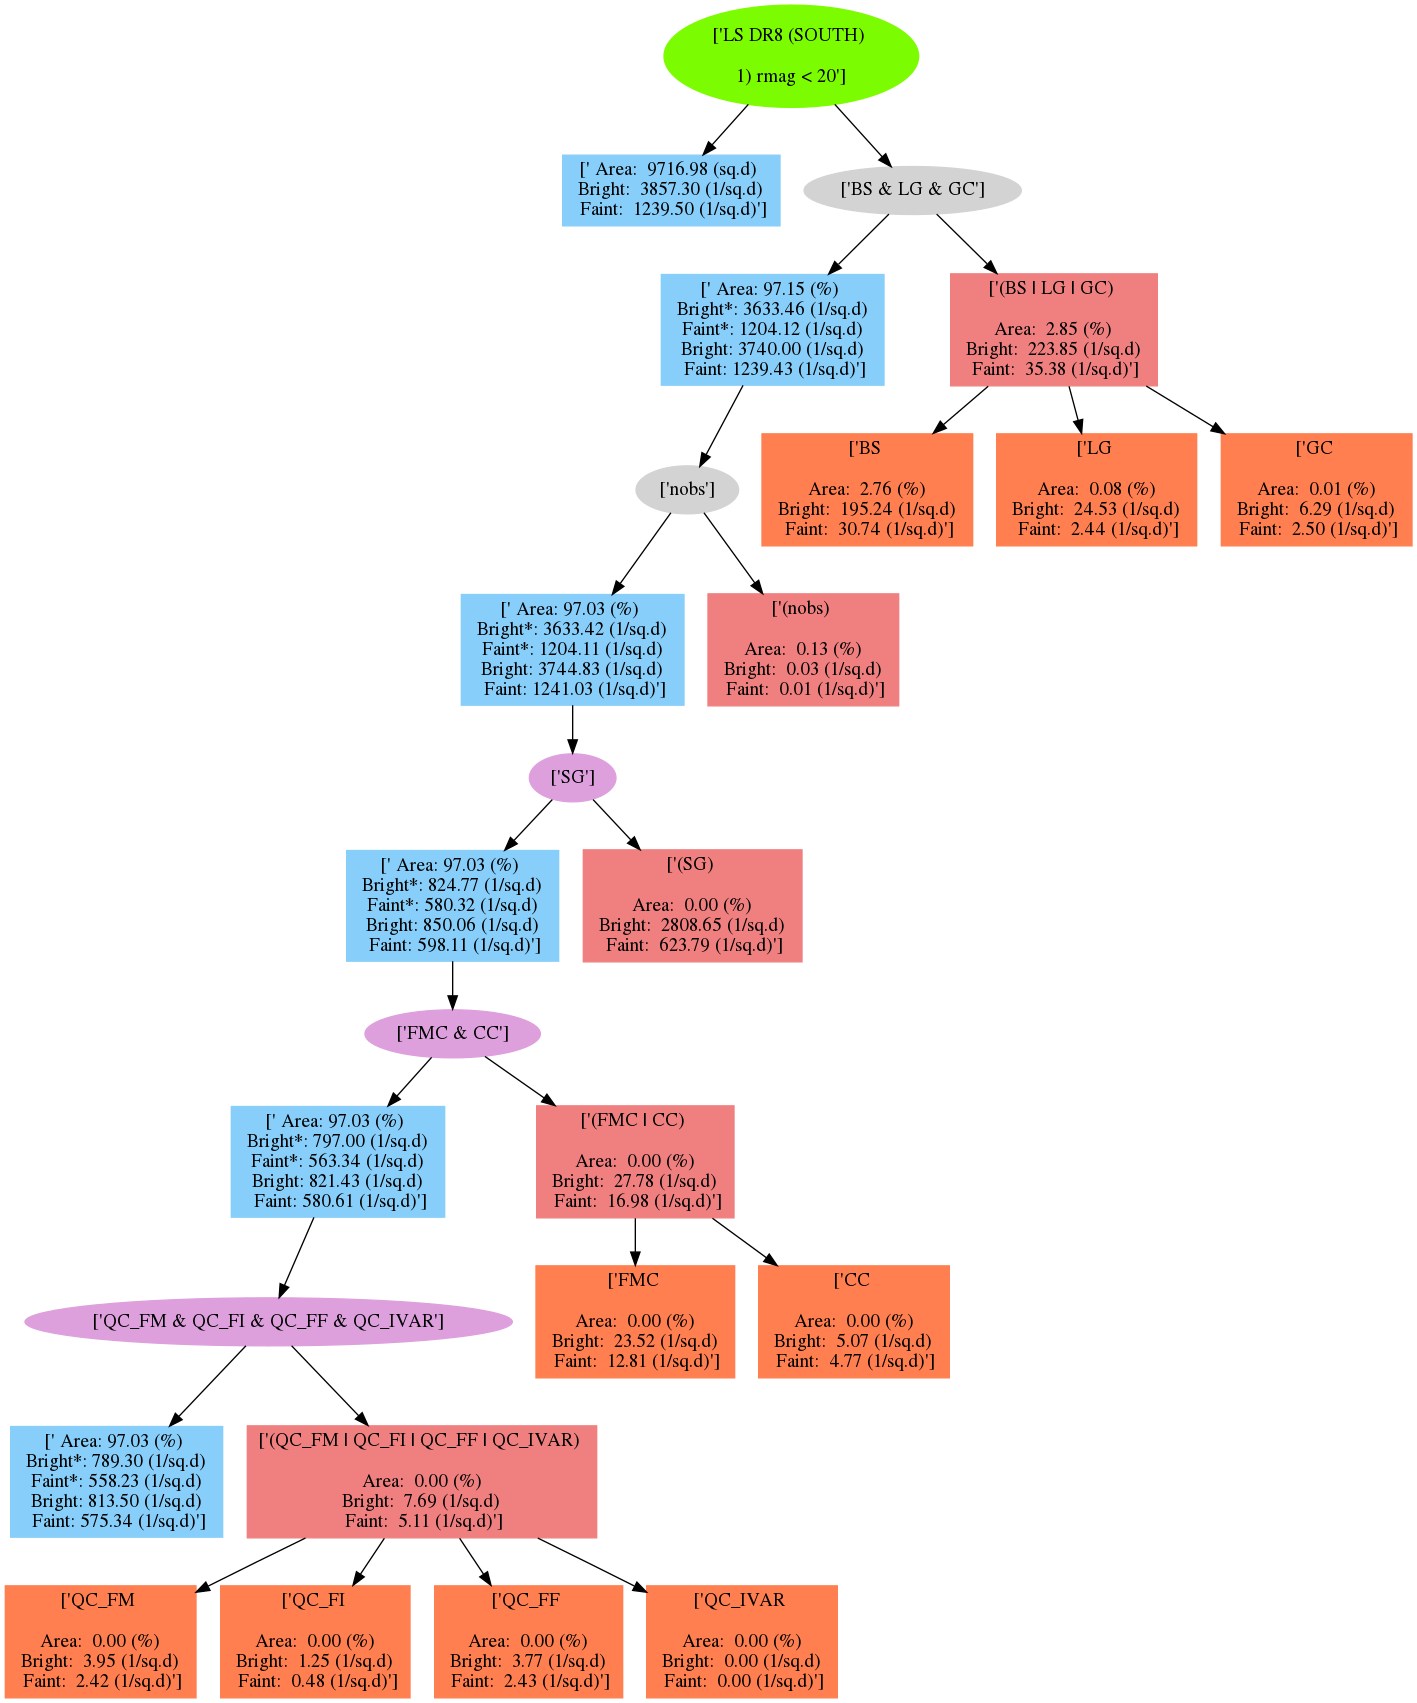

In [16]:
#
order = [['BS', 'LG', 'GC'], ['nobs'], ['SG'], ['FMC', 'CC'], ['QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']]
#order = [['SG'], ['BS', 'MS'], ['FMC', 'CC']]
flowphot, _, _ = flow(cat=cat, hpdict=hpdict, bgsmask=bgsmask(), rancuts=rancuts, order=order, reg=reg, 
             regcat=catinreg, regran=raninreg, file=resultsdir+'flow_default')

flowphot

## Galaxy view

Previous Cuts: (None)
Current Cuts: (SG)
Previous Cuts: (SG)
Current Cuts: (BS|LG|GC)
Previous Cuts: (SG|BS|LG|GC)
Current Cuts: (nobs)
Previous Cuts: (SG|BS|LG|GC|nobs)
Current Cuts: (QC_FM|QC_FI|QC_FF|QC_IVAR)
Previous Cuts: (SG|BS|LG|GC|nobs|QC_FM|QC_FI|QC_FF|QC_IVAR)
Current Cuts: (FMC|CC)


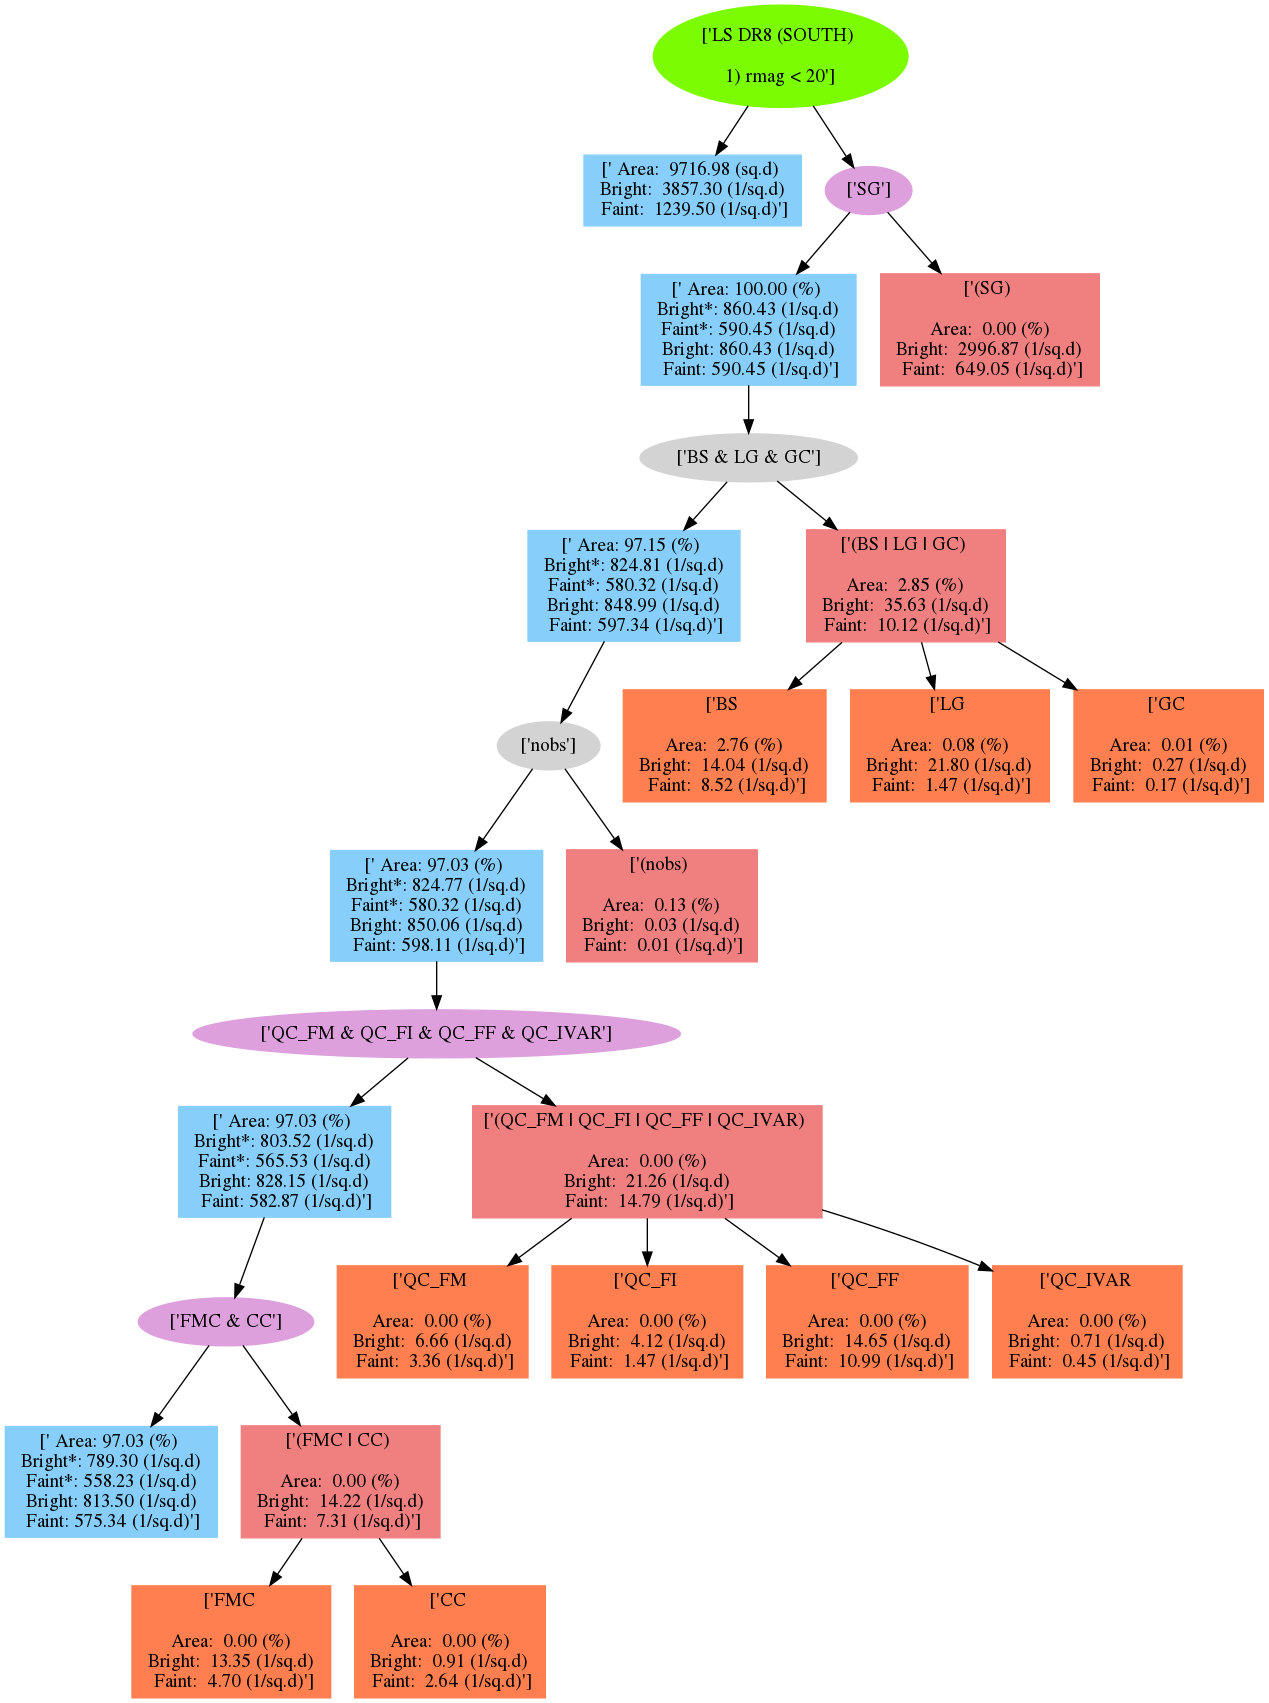

In [26]:
#
order = [ ['SG'], ['BS', 'LG', 'GC'], ['nobs'], ['QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR'], ['FMC', 'CC']]
#order = [['SG'], ['BS', 'MS'], ['FMC', 'CC']]
flowgal, _, _ = flow(cat=cat, hpdict=hpdict, bgsmask=bgsmask(), rancuts=rancuts, order=order, reg=reg, 
             regcat=catinreg, regran=raninreg, file=resultsdir+'flow_galaxy')

flowgal

# colour plots

In [17]:
t = getStats(cat=cat, hpdict=hpdict, bgsmask=bgsmask(), rancuts=rancuts, CurrentMask=['BS', 'LG', 'GC', 'nobs'], PrevMask=None, 
                 reg=reg, regcat=catinreg, regran=raninreg)

Previous Cuts: (None)
Current Cuts: (BS|LG|GC|nobs)


In [18]:
from main_def import get_mag_decals

finite = np.ones_like(cat['RMAG'], dtype='?')
for i in ['RMAG', 'GMAG', 'ZMAG','FLUX_R', 'RFIBERMAG']:
    finite &= np.isfinite(cat[i])
                          
bgs = (cat['BGSBITS'] & 2**(15)) != 0
Grr = cat['G'] - flux_to_mag(cat['FLUX_R'])

# get BGS objects without SG bit set on
bgsbutsg = np.ones_like(cat['RA'], dtype='?')
for key, val in zip(bgsmask().keys(), bgsmask().values()):
    if (key == 'allmask') or (key == 'MS') or (key == 'SG'): continue
    else: bgsbutsg &= (cat['BGSBITS'] & 2**(val)) != 0
            
# get BGS objects without FMC bit set on
bgsbutfmc = np.ones_like(cat['RA'], dtype='?')
for key, val in zip(bgsmask().keys(), bgsmask().values()):
    if (key == 'allmask') or (key == 'MS') or (key == 'FMC'): continue
    else: bgsbutfmc &= (cat['BGSBITS'] & 2**(val)) != 0
        
# reduced area
Ared = hpdict['bgsarea_'+reg]*(t[-1][1]/100.)
            
print('N BGS: %i' %(np.sum(bgs)))
print('N BGS but SG: %i' %(np.sum(bgsbutsg)))
print('N BGS but FMC: %i' %(np.sum(bgsbutfmc)))
print('Reduced area: %.2f' %(Ared))
                          

N BGS: 19780933
N BGS but SG: 64907196
N BGS but FMC: 20025354
Reduced area: 9428.39


In [19]:
from main_def import hexbin
from main_def import limits

## Grr vs g-z: bgsbutsg & south

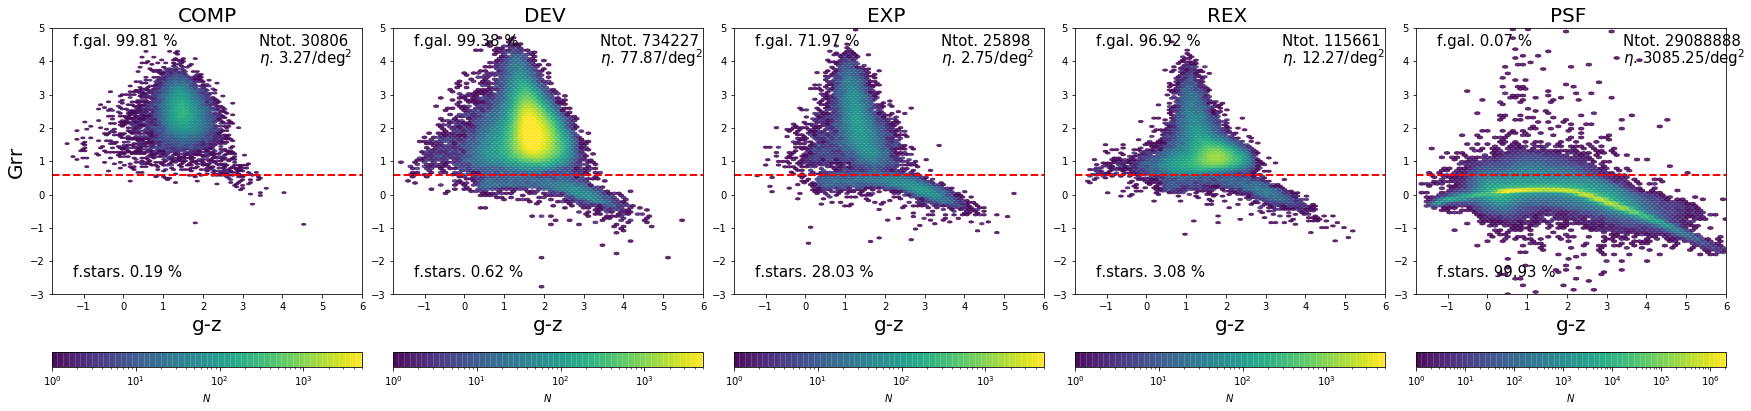

In [20]:
#
coord = {'g-z':cat['GMAG'] - cat['ZMAG'], 'Grr':Grr}
morphos = ['COMP', 'DEV ', 'EXP ', 'REX ', 'PSF ']
#morphos = ['REX ']
mask = (catinreg) & (bgsbutsg) & (finite)
hline, vline = 0.6, None
vmin, vmax = 1, 5000
    
fig    = plt.figure(figsize=(6*len(morphos),7))
gs     = gridspec.GridSpec(1,len(morphos),hspace=0.10,wspace=0.10)
    
for i, morpho in enumerate(morphos):
        
    if (i%len(morphos)==0): ylab=True
    else: ylab = False
    if morpho == 'PSF ': vmax = None
        
    morphomask = cat['TYPE'] == morpho
    hexbin(coord=coord, catmask=((mask) & (morphomask)), n=i, bins='log', title=morpho, cmap='viridis', 
               ylab=ylab, vline=vline, hline=hline, fig=fig, gs=gs, vmin=vmin, vmax=vmax, mincnt=1, 
                   file=resultsdir+'gz_Grr_bgsbutsg_hexbin', fracs=True, area=Ared)
        

## r vs rfibmag: bgsbutfmc & south

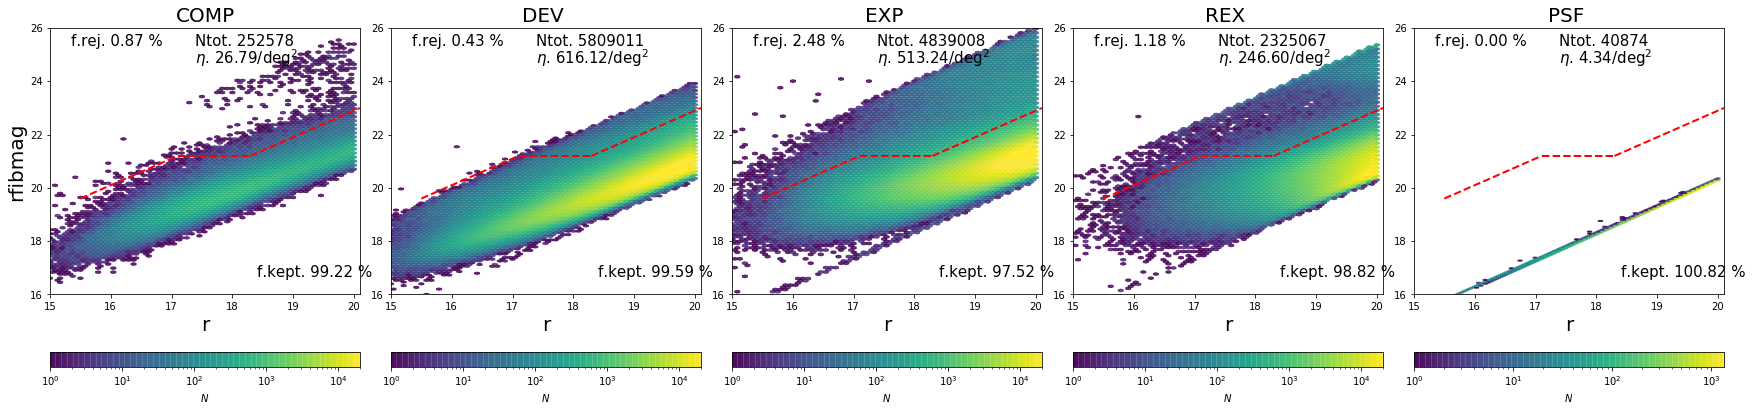

In [31]:
#
coord = {'r':cat['RMAG'], 'rfibmag':cat['RFIBERMAG']}
morphos = ['COMP', 'DEV ', 'EXP ', 'REX ', 'PSF ']
#morphos = ['COMP']
mask = (catinreg) & (bgsbutfmc) & (finite)
hline, vline = None, None
vmin, vmax = 1, 20000
    
fig    = plt.figure(figsize=(6*len(morphos),7))
gs     = gridspec.GridSpec(1,len(morphos),hspace=0.10,wspace=0.10)
    
for i, morpho in enumerate(morphos):
        
    if (i%len(morphos)==0): ylab=True
    else: ylab = False
    if morpho == 'PSF ': vmax = None
        
    morphomask = cat['TYPE'] == morpho
    hexbin(coord=coord, catmask=((mask) & (morphomask)), n=i, bins='log', title=morpho, cmap='viridis', 
               ylab=ylab, vline=vline, hline=hline, fig=fig, gs=gs, vmin=vmin, vmax=vmax, mincnt=1, fmcline=True, 
                   file=resultsdir+'r_rfibmag_bgsbutfmc_hexbin', area=Ared)
        

## g-r vs r-z: bgs & south

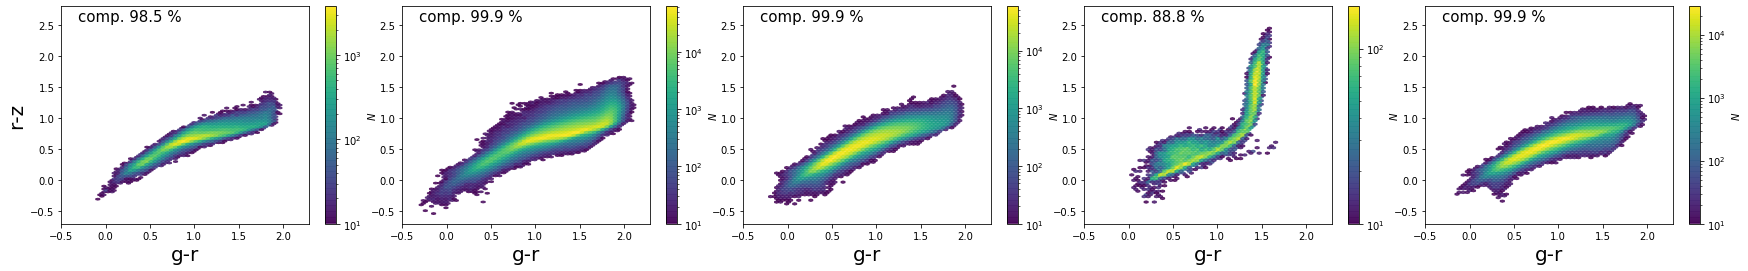

In [24]:
#
coord = {'g-r':cat['GMAG'] - cat['RMAG'], 'r-z':cat['RMAG'] - cat['ZMAG']}
morphos = ['COMP', 'DEV ', 'EXP ', 'PSF ', 'REX ']
mask = (catinreg) & (bgs) & (finite)
hline, vline = None, None
    
fig    = plt.figure(figsize=(6*len(morphos),4))
gs     = gridspec.GridSpec(1,len(morphos),hspace=0.10,wspace=0.10)
    
for i, morpho in enumerate(morphos):
        
    if (i%len(morphos)==0): ylab=True
    else: ylab = False
        
    morphomask = cat['TYPE'] == morpho
    hexbin(coord=coord, catmask=((mask) & (morphomask)), n=i, bins='log', title=None, cmap='viridis', 
               ylab=ylab, vline=vline, hline=hline, fig=fig, vmin=None, mincnt=10, file=resultsdir+'gr_rz_bgs_hexbin')
        

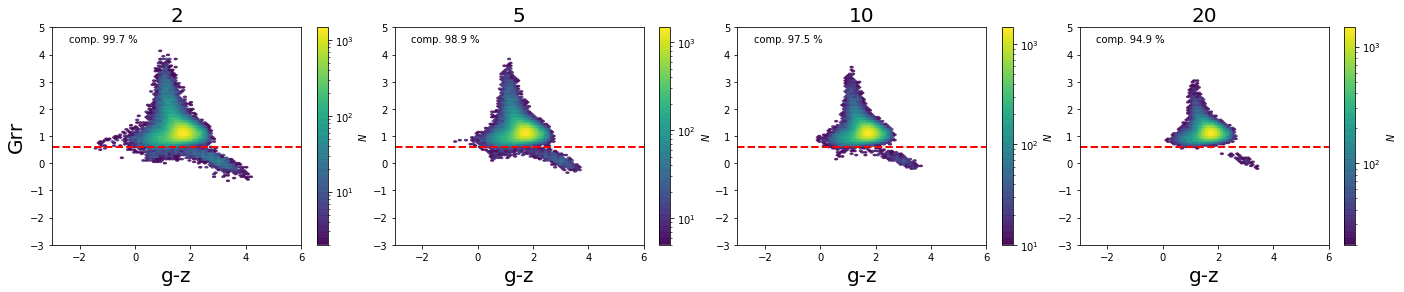

In [112]:
#
coord = {'g-z':cat['GMAG'] - cat['ZMAG'], 'Grr':Grr}
#morphos = ['COMP', 'DEV ', 'EXP ', 'PSF ', 'REX ']
#morphos = ['REX ']
mask = (catinreg) & (bgsbutsg) & (finite)
hline, vline = 0.6, None
mincnts = [2, 5, 10, 20]
    
fig    = plt.figure(figsize=(6*len(mincnts),4))
gs     = gridspec.GridSpec(1,len(mincnts),hspace=0.10,wspace=0.10)
    
for i, mincnt in enumerate(mincnts):
        
    if (i%len(mincnts)==0): ylab=True
    else: ylab = False
        
    morphomask = cat['TYPE'] == 'REX '
    pos = hexbin(coord=coord, catmask=((mask) & (morphomask)), n=i, bins='log', title=str(mincnt), cmap='viridis', 
               ylab=ylab, vline=vline, hline=hline, fig=fig, vmin=None, mincnt=mincnt)
        

# DEV ZONE...

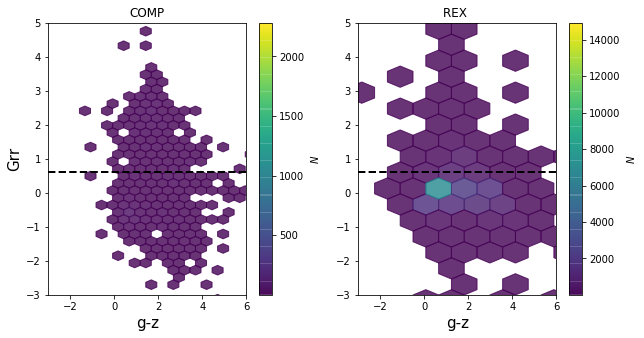

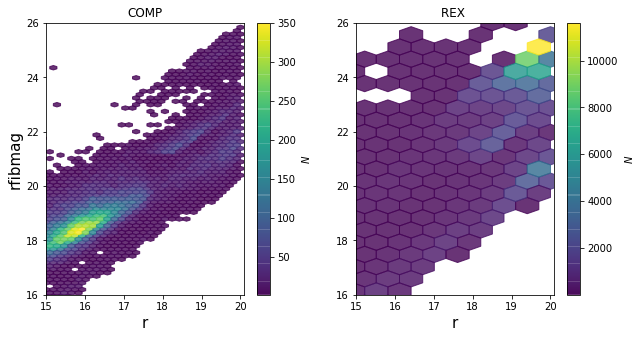

In [71]:
#
coord0 = {'g-z':cat['GMAG'] - cat['ZMAG'], 'Grr':Grr}
coord1 = {'r':cat['RMAG'], 'rfibmag':cat['RFIBERMAG']}
#morphos = ['COMP', 'DEV ', 'EXP ', 'PSF ', 'REX ']
morphos = ['COMP', 'REX ']
mask = (catinreg) & (bgs) & (finite)

for coord in [coord0, coord1]:
    
    hline, vline = None, None
    
    if 'Grr' in coord.keys(): hline = 0.6
    
    fig    = plt.figure(figsize=(5*len(morphos),5))
    gs     = gridspec.GridSpec(1,len(morphos),hspace=0.30,wspace=0.25)
    
    for i, morpho in enumerate(morphos):
        
        if (i%len(morphos)==0): ylab=True
        else: ylab = False
        
        morphomask = cat['TYPE'] == morpho
        hexbin(coord=coord, catmask=((mask) & (morphomask)), n=i, title=morpho, cmap='viridis', ylab=ylab, vline=vline, hline=hline, fig=fig)
        

In [12]:
def limits():
    
    limits = {}
    limits['Grr'] = (-2, 5)
    limits['g-z'] = (-1.8, 6)
    limits['r'] = (15, 20.1)
    limits['rfibmag'] = (16, 26)
    limits['g-r'] = (-0.5, 2.3)
    limits['r-z'] = (-0.7, 2.8)
    
    return limits

def hexbin(coord, catmask, n, C=None, bins=None, title=None, cmap='viridis', ylab=False, vline=None, 
           hline=None, fig=None, xlim=None, ylim=None, vmin=None, mincnt=1, fmcline=False, file=None):
    
    x, y = coord.keys()
    
    ax = fig.add_subplot(gs[n])
    if title is not None: ax.set_title(r'%s' %(title), size=20)
    if xlim is None: xlim = limits()[x]
    if ylim is None: ylim = limits()[y]
    masklims = (coord[x] > xlim[0]) & (coord[x] < xlim[1]) & (coord[y] > ylim[0]) & (coord[y] < ylim[1])
        
    pos = ax.hexbin(coord[x][(catmask) & (masklims)], coord[y][(catmask) & (masklims)], C=C, gridsize=(60,60), cmap=cmap, 
                    vmin=vmin, bins=bins, mincnt=mincnt, alpha=0.8)
    ax.set_xlabel(r'%s' %(x), size=20)
    
    dx = np.abs(xlim[1] - xlim[0])/15.
    dy = np.abs(ylim[1] - ylim[0])/15.
    ax.text(xlim[0]+dx, ylim[1]-dy, r'comp. %2.3g %%' %(100 * np.sum(pos.get_array())/np.sum((catmask) & (masklims))), size=15)
    if ylab: ax.set_ylabel(r'%s' %(y), size=20)
    if hline is not None: ax.axhline(hline, ls='--', lw=2, c='r')
    if vline is not None: ax.axvline(vline, ls='--', lw=2, c='r')
    if fmcline: 
        x_N1 = np.linspace(15.5, 17.1, 4)
        ax.plot(x_N1, 2.9 + 1.2 + x_N1, color='r', ls='--', lw=2)
        x_N2 = np.linspace(17.1, 18.3, 4)
        ax.plot(x_N2, x_N2*0.+21.2, color='r', ls='--', lw=2)
        x_N3 = np.linspace(18.3, 20.1, 4)
        ax.plot(x_N3, 2.9 + x_N3, color='r', ls='--', lw=2)
        
    #if bins is not None: clab = r'$\log(N)$'
    clab = r'$N$'
    fig.colorbar(pos, ax=ax, label=clab)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    
    if file is not None:
        fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)
        